In [163]:
import tensorflow as tf
from tensorflow.keras import models, layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers.convolutional import*

from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
import tensorflow_hub as hub

import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow_hub'

In [99]:
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 384
BATCH_SIZE = 10
CHANNELS = 3
EPOCHS = 10

In [100]:
dataset = tf.keras.utils.image_dataset_from_directory(
    'new_data',
    shuffle=True,
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size = BATCH_SIZE
)

#dataset = dataset.shuffle(buffer_size=50)

Found 636 files belonging to 3 classes.


In [101]:
class_names = dataset.class_names
class_names

['compost', 'recycle', 'trash']

In [102]:
len(dataset)

64

In [103]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)

# output: 10 images in batch, each image is 512x384, 3 color channels (RGB)

(10, 512, 384, 3)


In [104]:
for image_batch, label_batch in dataset.take(1):
    print(label_batch)

# output: the class labels for the first 10 images

tf.Tensor([1 0 0 1 0 1 1 2 1 1], shape=(10,), dtype=int32)


In [105]:
def display_first_ten_images():
    
    plt.figure(figsize=(10,10))
    for image_batch, label_batch in dataset.take(1):
        for i in range(10):
            ax = plt.subplot(2,5,i+1)
            plt.imshow(image_batch[i].numpy().astype(int))
            plt.title(class_names[label_batch[i]])
            plt.axis('off')

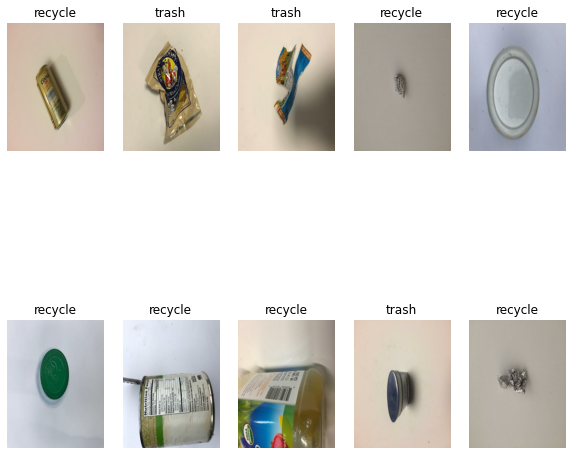

In [106]:
display_first_ten_images()

### create train-test-validation split

In [107]:
def create_train_test_validation_splits(data, shuffle=True, shuffle_size=10000):
    
    # shuffle data before splitting data
    if shuffle:
        data = data.shuffle(shuffle_size, seed=6)
    
    train_split = 0.8
    test_split = 0.1
    val_split = 0.1
    
    train_size = int(train_split * len(data))
    test_size = int(test_split * len(data))
    
    # create partitioned datasets
    train = data.take(train_size)
    test = data.skip(train_size).take(test_size)
    val = data.skip(train_size).skip(test_size)
    
    return train, test, val

In [108]:
train, test, val = create_train_test_validation_splits(dataset)

In [109]:
print(f'train size: {len(train)} batches')
print(f'test size: {len(test)} batches')
print(f'validation size: {len(val)} batches')

train size: 51 batches
test size: 6 batches
validation size: 7 batches


In [110]:
# optimizing datasets for training performance
train = train.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val = val.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

### Pre-processing

In [156]:
# create pre-processing pipeline

prepoc = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
    layers.experimental.preprocessing.Rescaling(1.0/255),
     
    # data augmentation
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    #layers.experimental.preprocessing.RandomRotation(0.2)
])

In [157]:
from keras.layers import BatchNormalization

In [158]:
INPUT_SHAPE = (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)

model = Sequential([
    prepoc,
    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=INPUT_SHAPE),
    MaxPooling2D((2,2)),
    #Conv2D(64, kernel_size=(3,3), activation='relu'),
    #MaxPooling2D((2,2)),
    #Conv2D(128, kernel_size=(3,3), activation='relu'),
    #MaxPooling2D((2,2)),
    Flatten(),
    #BatchNormalization(axis=1),
    #Dense(64, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

In [159]:
model.build(input_shape=INPUT_SHAPE)

In [160]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_20 (Sequential)  (10, 512, 384, 3)         0         
                                                                 
 conv2d_30 (Conv2D)          (10, 510, 382, 32)        896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (10, 255, 191, 32)       0         
 g2D)                                                            
                                                                 
 flatten_15 (Flatten)        (10, 1558560)             0         
                                                                 
 dense_22 (Dense)            (10, 3)                   4675683   
                                                                 
Total params: 4,676,579
Trainable params: 4,676,579
Non-trainable params: 0
___________________________________________

In [161]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [162]:
model.fit(
    train,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val
)

Epoch 1/20
51/51 [==============================] - 32s 606ms/step - loss: 14.5448 - accuracy: 0.6126 - val_loss: 2.2069 - val_accuracy: 0.6857
Epoch 2/20
51/51 [==============================] - 30s 581ms/step - loss: 0.7548 - accuracy: 0.7312 - val_loss: 0.8601 - val_accuracy: 0.8143
Epoch 3/20
51/51 [==============================] - 28s 548ms/step - loss: 0.8174 - accuracy: 0.7945 - val_loss: 0.6085 - val_accuracy: 0.8000
Epoch 4/20
51/51 [==============================] - 29s 561ms/step - loss: 0.6339 - accuracy: 0.7984 - val_loss: 0.5913 - val_accuracy: 0.8714
Epoch 5/20
51/51 [==============================] - 28s 541ms/step - loss: 0.4445 - accuracy: 0.8399 - val_loss: 0.5631 - val_accuracy: 0.8000
Epoch 6/20
51/51 [==============================] - 27s 526ms/step - loss: 0.3167 - accuracy: 0.8893 - val_loss: 0.4291 - val_accuracy: 0.8714
Epoch 7/20
51/51 [==============================] - 28s 552ms/step - loss: 0.2424 - accuracy: 0.9130 - val_loss: 0.3714 - val_accuracy: 0.885